In [49]:
import scienceplots
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model
import os
import sys

sys.path.append("../..")

from blume.process import read, compute, plot_file
from blume.run import Results, ModelParameters
from blume.model.post_props import Prop

plt.style.use("science")
plt.rcParams["text.usetex"] = True

In [50]:
data = read("papers", "Zierenberg et al")
temps_Z, deltas_Z, errors_Z = tuple(zip(*data["Zierenberg"]["data"]))
deltas_M, temps_M, errors_M = tuple(zip(*data["Malakis"]["data"]))
temps_K, deltas_K, errors_K = tuple(zip(*data["Kwak"]["data"]))



In [51]:
deltas_M[7]

1.975

In [52]:
temps_M

(1.693, 1.564, 1.398, 1.151, 0.958, 0.769, 0.659, 0.574)

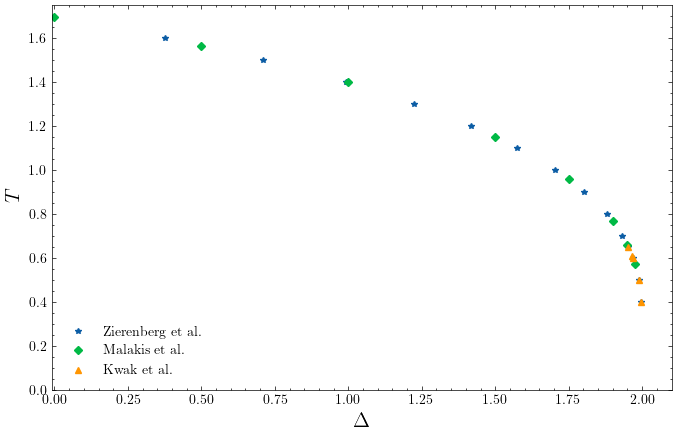

In [53]:
plt.figure(figsize = (8, 5))
plt.plot(deltas_Z, temps_Z, "*", markersize = 4, label = "Zierenberg et al.")
plt.plot(deltas_M, temps_M, "D", markersize = 4, label = "Malakis et al.")
plt.plot(deltas_K, temps_K, "^", markersize = 5, label = "Kwak et al.")

plt.plot()
plt.xlim(-0.01, 2.1)
plt.ylim(0, 1.75)
plt.xlabel("$\Delta$", fontsize = 15)
plt.legend(loc = "lower left")
plt.ylabel("$T$", fontsize = 15)
plt.show()

In [54]:
result = Results(varying_param="chi", range=[6, 8, 12, 18])
params = ModelParameters(model = "blume", var_range=(0.55, 0.65), step=0.0005, tol=1e-9, max_steps=int(10e9), use_prev=True, coupling = 1.975)
result.get(params, sweeping_param= "temperature")

chi=6:  24%|██▎       | 47/200 [00:05<00:16,  9.01it/s]


KeyboardInterrupt: 

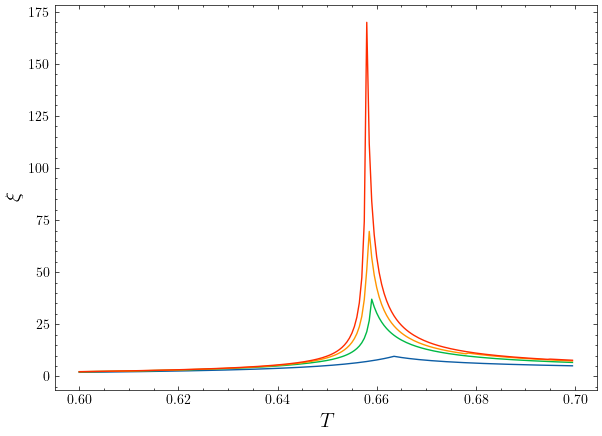

In [55]:
plt.figure(figsize = (7, 5))
max_corrs = []
T_stars = []
for chi in [4, 8, 12, 18]:
    data = read("20-05 14:51", f"chi{chi}")
    corrs = compute(Prop.xi, data)
    plt.plot(data["temperatures"], corrs, label = f"$\chi = {chi}$")

    idx = corrs.index(max(corrs))
    T_stars.append(data["temperatures"][idx])
    max_corrs.append(max(corrs))

plt.ylabel(r"$\xi$", fontsize = 15)
plt.xlabel("$T$", fontsize = 15)
plt.show()
    

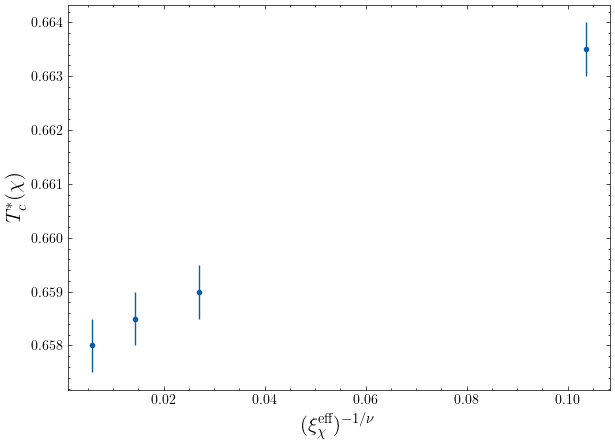

In [56]:
chis = [4, 8, 12, 18]
corrs_inv = [1/corr for corr in max_corrs]
plt.figure(figsize=(7, 5))
plt.errorbar(corrs_inv, T_stars, fmt = "o", yerr = 0.0005, markersize = 3)
plt.ylabel("$T^*_c(\chi)$", fontsize = 15)
plt.xlabel(r"$(\xi_{\chi}^{\text{eff}})^{-1/ \nu}$", fontsize=15)
plt.show()

In [57]:
model = Model(lambda x, a, b: a*x + b)

T_crits = []

for folder in ["20-05 13:33", "20-05 13:44", "20-05 13:57","20-05 14:15", "20-05 13:16", "20-05 14:32", "20-05 14:51"]:

    T_stars = []
    max_corrs = []
    for file in os.listdir(os.path.join("../../data", folder)):

        data = read(folder, file[:-5])
        corrs = compute(Prop.xi, data)
        idx = corrs.index(max(corrs))
        T_stars.append(data["temperatures"][idx])
        max_corrs.append(max(corrs))

    x = [1/corr for corr in max_corrs]
    y = T_stars
    params = model.make_params(a=0.5, b=0.5)
    result = model.fit(y, params, x=x, weights = 1 / 0.0005)
    T_crits.append((result.params['b'].value, result.params['b'].stderr))


In [58]:
T_crits, errors = list(zip(*T_crits))
deltas = [0, 0.5,1,1.5, 1.75, 1.9, 1.95]

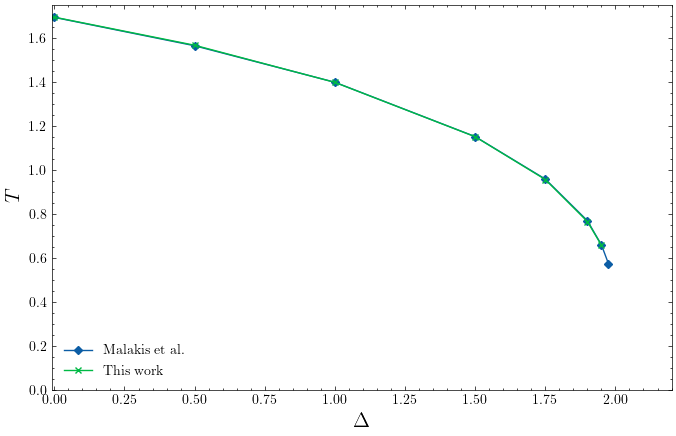

In [59]:
plt.figure(figsize = (8, 5))
plt.plot(deltas_M, temps_M, "D-", markersize = 4, label = "Malakis et al.")
plt.plot(deltas, T_crits, "x-", markersize = 4, label = "This work")
plt.xlim(-0.01, 2.2)
plt.ylim(0, 1.75)
plt.xlabel("$\Delta$", fontsize = 15)
plt.ylabel("$T$", fontsize = 15)
plt.legend(loc = "lower left")

plt.show()

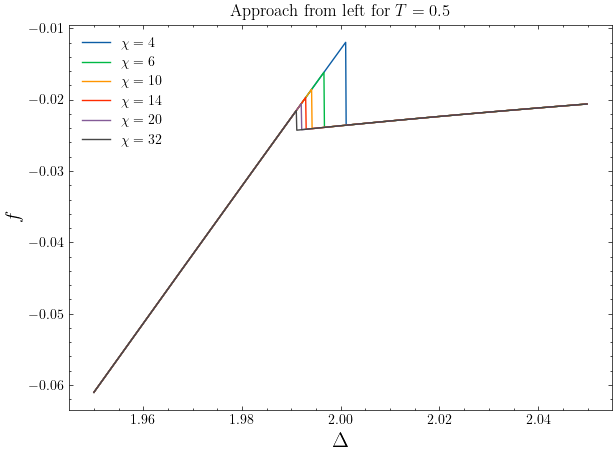

In [60]:
plt.figure(figsize = (7, 5))
for chi in [4, 6, 10, 14, 20, 32]:    
    data = read("21-05 16:46", f"chi{chi}")
    plt.plot(data["couplings"], compute(Prop.f, data), label=f"$\chi = {chi}$")

plt.xlabel("$\Delta$", fontsize = 15)
plt.ylabel("$f$", fontsize = 15)
plt.legend()
plt.title("Approach from left for $T = 0.5$")
plt.show()

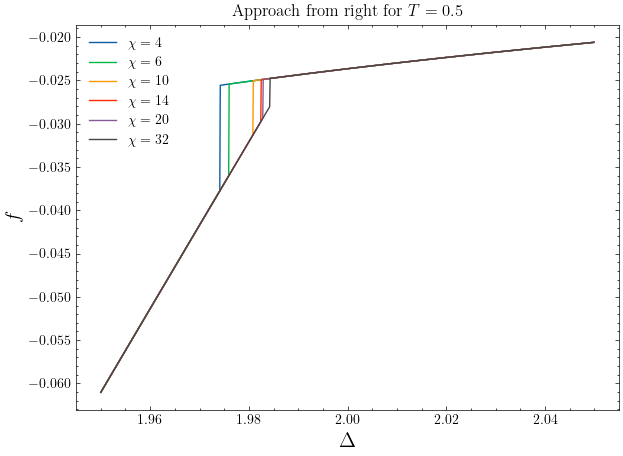

In [61]:
plt.figure(figsize = (7, 5))
for chi in [4, 6, 10, 14, 20, 32]:    
    data = read("21-05 16:54", f"chi{chi}")
    plt.plot(data["couplings"], compute(Prop.f, data), label=f"$\chi = {chi}$")

plt.xlabel("$\Delta$", fontsize = 15)
plt.ylabel("$f$", fontsize = 15)
plt.legend()
plt.title("Approach from right for $T = 0.5$")
plt.show()

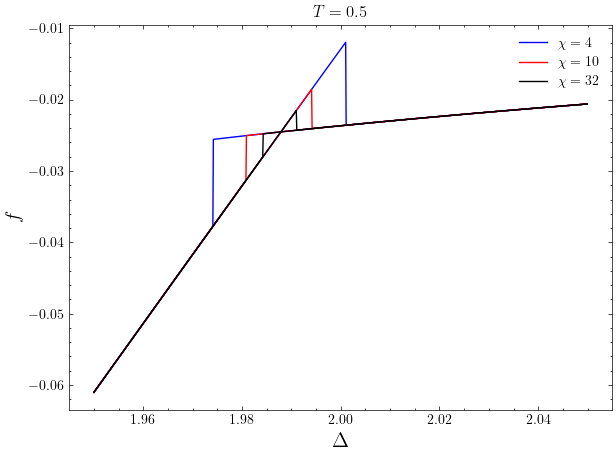

In [62]:
plt.figure(figsize = (7, 5))
colors = ["b-", "r-", "k-"]
for idx, chi in enumerate([4, 10, 32]):    
    data_inv = read("21-05 16:54", f"chi{chi}")
    data = read("21-05 16:46", f"chi{chi}")
    plt.plot(data["couplings"], compute(Prop.f, data), colors[idx], label=f"$\chi = {chi}$")
    plt.plot(data_inv["couplings"], compute(Prop.f, data_inv), colors[idx])

plt.title("$T = 0.5$")
plt.xlabel("$\Delta$", fontsize = 15)
plt.ylabel("$f$", fontsize = 15)
plt.legend()
plt.show()

In [63]:
def intersect(idx_slice, inv_data, data):
    free_energies = compute(Prop.f, data)
    inv_free_energies = compute(Prop.f, inv_data)

    inv_free_energies.reverse()
    subtracted = [abs(el1 - el2) for (el1, el2) in zip(free_energies, inv_free_energies)]
    subtracted = subtracted[idx_slice[0]:idx_slice[1]]
    couplings = data["couplings"][idx_slice[0]:idx_slice[1]]
    idx = subtracted.index(min(subtracted))
    return couplings[idx]


In [64]:
inv_data = read("21-05 16:54", f"chi{32}")
data = read("21-05 16:46", f"chi{32}")
deltas.append(intersect((350, 400), inv_data, data))

In [65]:
inv_data = read("22-05 11:23", f"data")
data = read("22-05 11:24", f"data")
deltas.append(intersect((425, 500), inv_data, data))

In [66]:
inv_data = read("22-05 15:38", f"data")
data = read("22-05 15:39", f"data")
deltas.append(intersect((200, 800), inv_data, data))

In [67]:
T_crits = list(T_crits)
T_crits.extend([0.5, 0.4, 0.3])

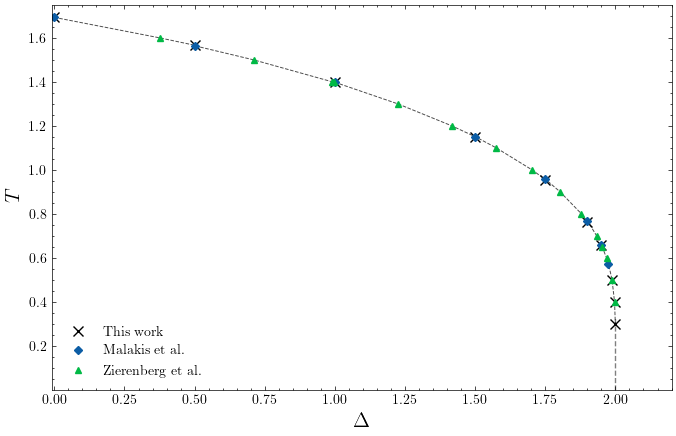

In [99]:
from matplotlib.ticker import MaxNLocator


plt.figure(figsize = (8, 5))



all_deltas, all_T_crits = [], []
all_deltas.extend(deltas)
all_deltas.extend(deltas_M) 
all_deltas.extend(deltas_Z)  
all_T_crits.extend(T_crits)
all_T_crits.extend(temps_M)
all_T_crits.extend(temps_Z)


plt.axvline(2, linestyle="--", color = "k", ymax =0.19, alpha=0.5)

all_T_crits = [x for _, x in sorted(zip(all_deltas, all_T_crits), key=lambda pair: pair[0])]
plt.plot(sorted(all_deltas), all_T_crits, "k--", linewidth = 0.7, alpha=0.7)



plt.plot(deltas, T_crits, "kx", markersize = 7, label = "This work")
plt.plot(deltas_M, temps_M, "D", markersize = 4, label = "Malakis et al.")
plt.plot(deltas_Z, temps_Z, "^", markersize = 5, label = "Zierenberg et al.")



plt.xlim(-0.01, 2.2)
plt.ylim(0, 1.75)
plt.xlabel("$\Delta$", fontsize = 15)
plt.ylabel("$T$", fontsize = 15)
plt.legend(loc = "lower left")
plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

## Second order 

In [ ]:
import pandas as pd


data = {"deltas": deltas[0:7], 'Malakis et al.': temps_M[0:7], 'This work': T_crits[0:7]}

df = pd.DataFrame.from_dict(data)
columns=[("", "deltas"), ('Malakis et al.','T'),('This work','T')]
df.columns=pd.MultiIndex.from_tuples(columns)
df

,,Malakis et al.,This work
,deltas,T,T
0,0.00,1.693,1.693976
1,0.50,1.564,1.566334
2,1.00,1.398,1.397580
3,1.50,1.151,1.150546
4,1.75,0.958,0.956046
5,1.90,0.769,0.765034
6,1.95,0.659,0.657618


In [ ]:
errors

## First Order

In [ ]:
table_deltas_Z = list(deltas_Z[13:])
table_deltas_Z.append("")
data = {"T": [0.5, 0.4, 0.3], '.': table_deltas_Z, 'This work': deltas[7:]}
df = pd.DataFrame.from_dict(data)
columns=[("", "T"), ('Zierenberg et al.','delta'),('This work','delta')]
df.columns=pd.MultiIndex.from_tuples(columns)
df.style.set_properties(**{'text-align': 'center'})
df

,,Zierenberg et al.,This work
,T,delta,delta
0,0.5,1.987889,1.9879
1,0.4,1.99683,1.9968
2,0.3,,1.9996
